# Project: Swedish Municipality KPI Analysis
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

### Problem Description

* What is the purpose of your study?  

The primary objective of this study is to explore and analyze the impact of higher education on population health in Swedish municipalities. This investigation aims to uncover the nuances of how educational attainment influences various health outcomes and social behaviors within these communities.

Specifically, the study will delve into the following key aspects:
* **The relationship between educational attainment and obesity:** 
Investigating whether lower educational attainment is associated with higher rates of obesity. 
* **The relationship between educational attainment and daily smoking:** 
Investigating the correlation between education levels and smoking habits.
* **The relationship between educational attainment and risky drinking:** 
Analyzing the impact of educational attainment on alcohol consumption patterns.

The study aims to provide insights into the broader significance of educational inconsistencies on public health and social behaviors. The findings are expected to contribute to a deeper understanding of the role of education in shaping health outcomes and social dynamics within Swedish municipalities, potentially informing policy decisions and community health initiatives. 

* Are there errors in the dataset? How did you deal with them? Explain your process and the reasoning behind it. 

* What are the (statistical) data types of the columns in your dataset? 
In our dataset we have a mix of nominal categorical data (`kpi`, `muncipality` and `gender`) and numerical data (`period` and `value`).
1. `kpi` (Key Performance Indicator ID): This column contains alphanumeric codes corresponding to the KPIs analyzed within this dataset. These are nominal data as they are used to identify the KPIs and do not have any inherent order or numerical value.
2. `municipality`: This column contains the names of the municipalities included in the dataset. These are nominal data  as they represent labels or identifiers for different municipalities and do not hold any quantitative value.
3. `period`: This column represents the year and is numerical and is considered as categorical data as it categorizes the data into different years.
4. `gender`: This column contains values K, M and T representing if there is a gender division for the datapoint. K for women, M for men and T for both.
5. `value`: This column contains the values for the KPIs. These are numerical data as they represent the actual values for the KPIs.

* Use a Q-Q plot to compare the distributions of different groups. What you are trying to observe? Why is it is important? Describe the results.

In [6]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the datasets
kpi_data_path = 'data/kpi_data.csv'
kpi_values_path = 'data/kpi_values.csv'
municipalities_data_path = 'data/municipalities_data.csv'

# Read the data
kpi_data = pd.read_csv(kpi_data_path)
kpi_values = pd.read_csv(kpi_values_path)
municipalities_data = pd.read_csv(municipalities_data_path)

# Displaying the first few rows of each dataset
kpi_data_head = kpi_data.head(5)
kpi_values_head = kpi_values.head(5)
municipalities_data_head = municipalities_data.head(5)

(kpi_data_head, kpi_values_head, municipalities_data_head)

(       id                                              title  \
 0  N00000  Personalkostnader som andel av verksamhetens k...   
 1  N00003                          Personalkostnader, kr/inv   
 2  N00005     Utjämningssystemet enl resultaträkning, kr/inv   
 3  N00009                   Intäkter kommunen totalt, kr/inv   
 4  N00011  Inkomstutjämning, bidrag/avgift, kr/inv. 1 nov...   
 
                                          description municipality_type  \
 0  Personalkostnader kommunen totalt, dividerat m...                 K   
 1  Personalkostnader kommunen totalt, dividerat m...                 K   
 2  Kommunalekonomisk utjämning kommun, dividerat ...                 K   
 3  Externa intäkter exklusive intäkter från försä...                 K   
 4  Inkomstutjämning, bidrag/avgift, i kronor per ...                 K   
 
    is_divided_by_gender  publ_period publication_date  
 0                     0          NaN              NaN  
 1                     0       2023.0     

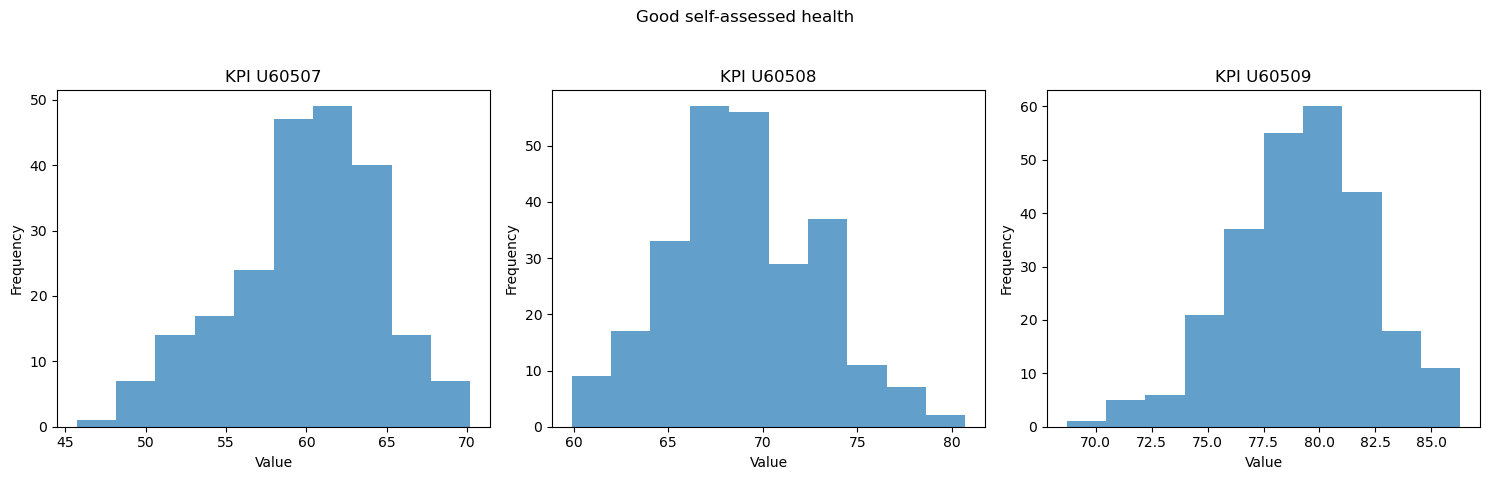

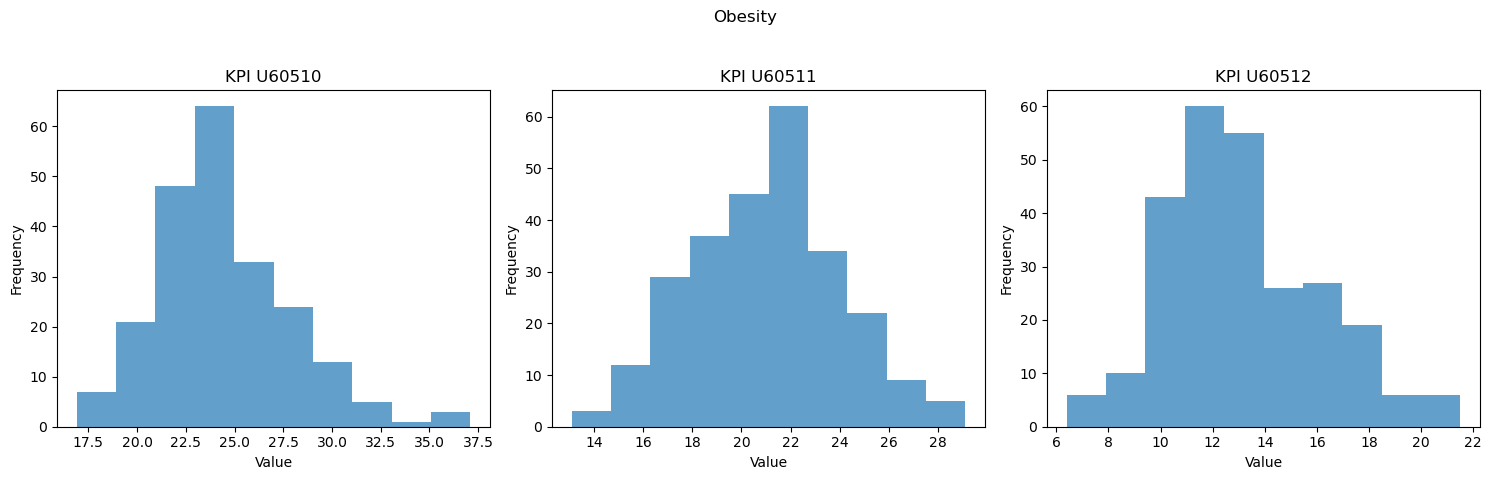

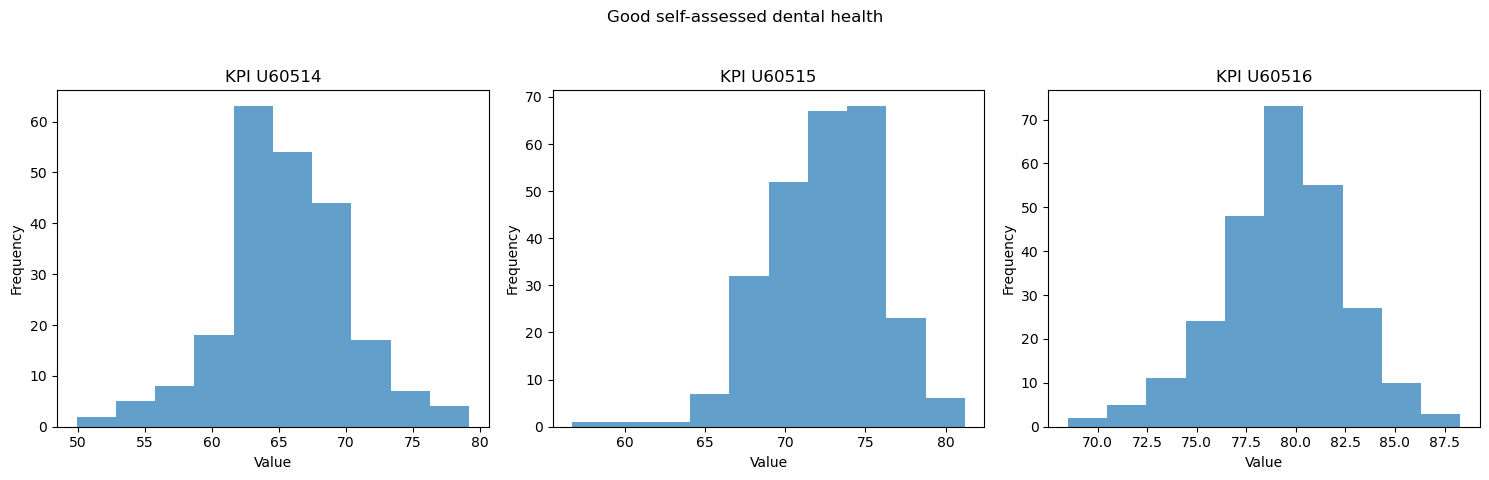

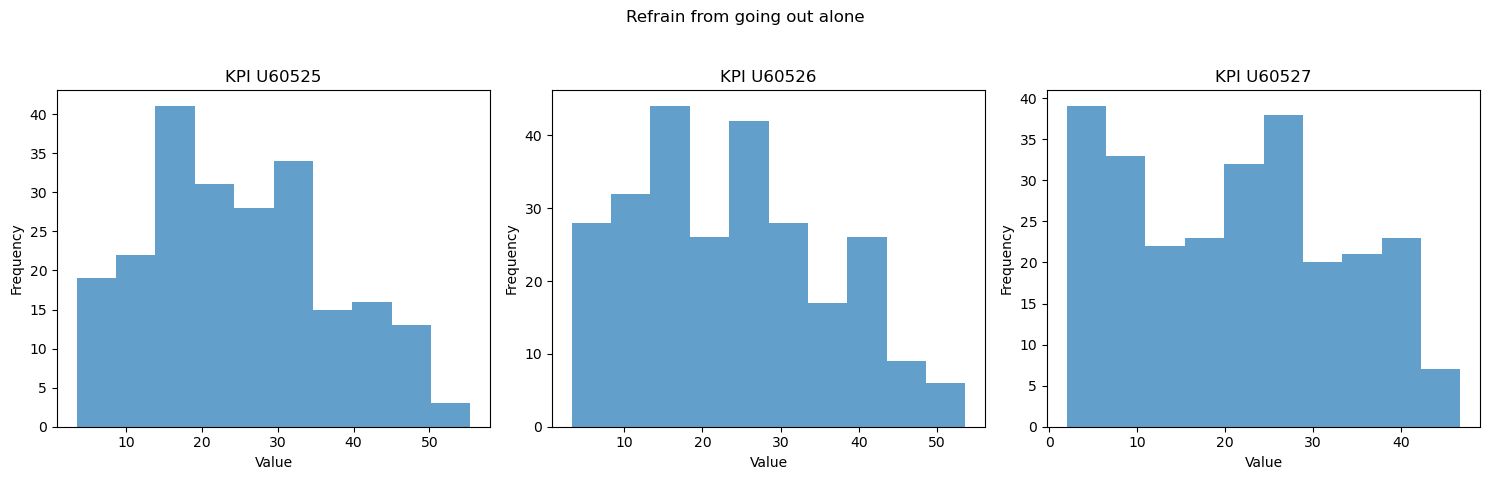

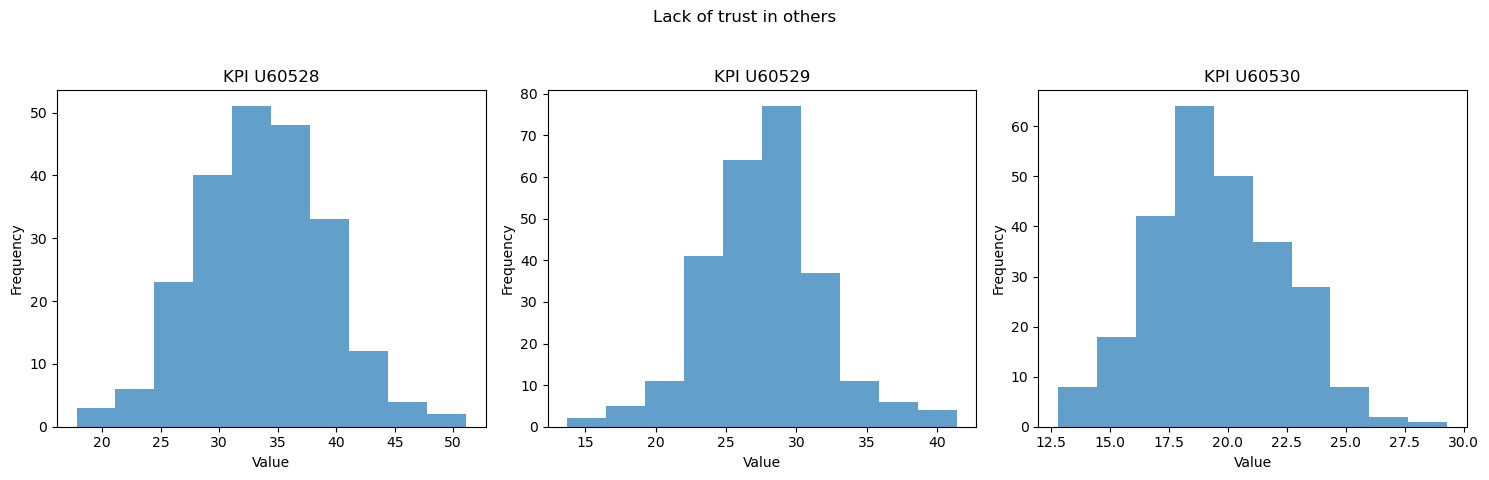

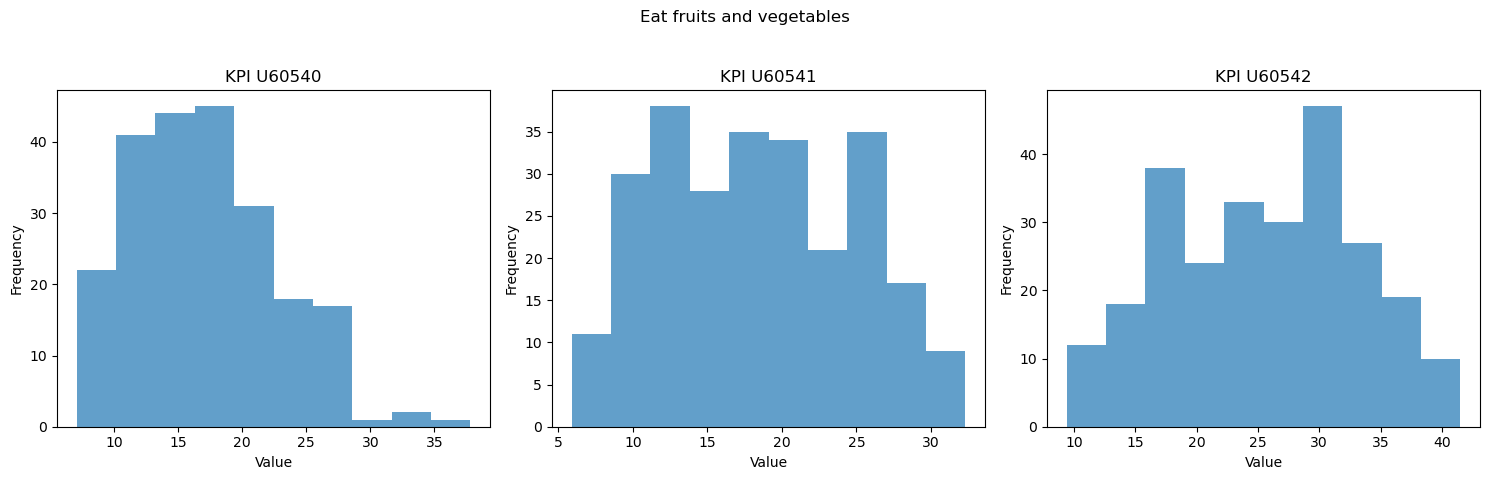

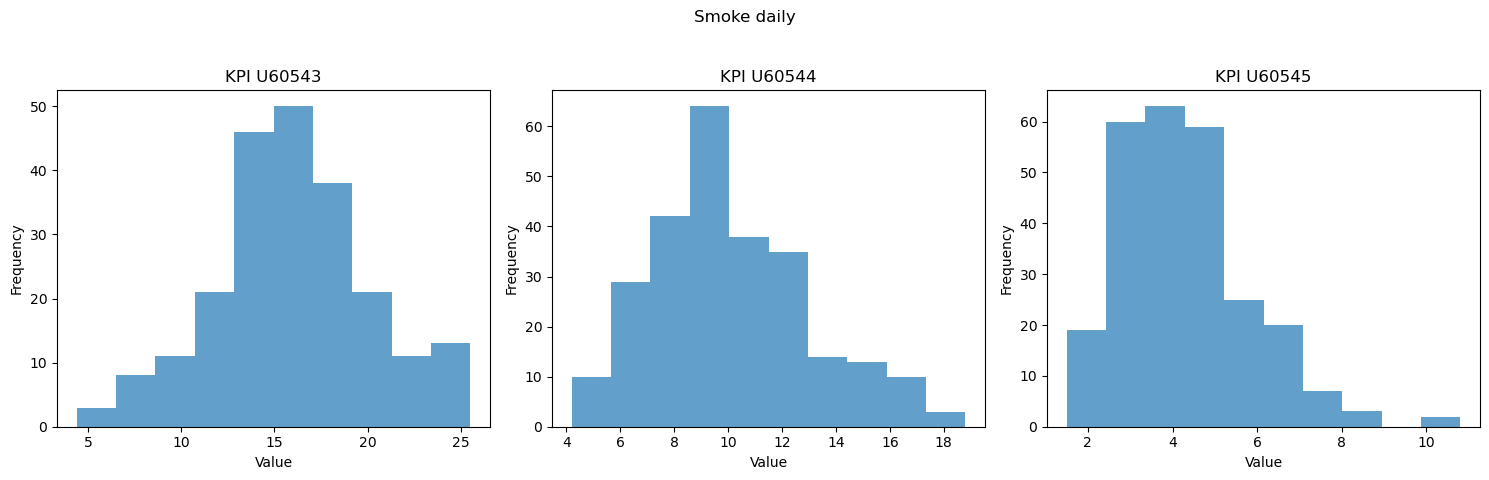

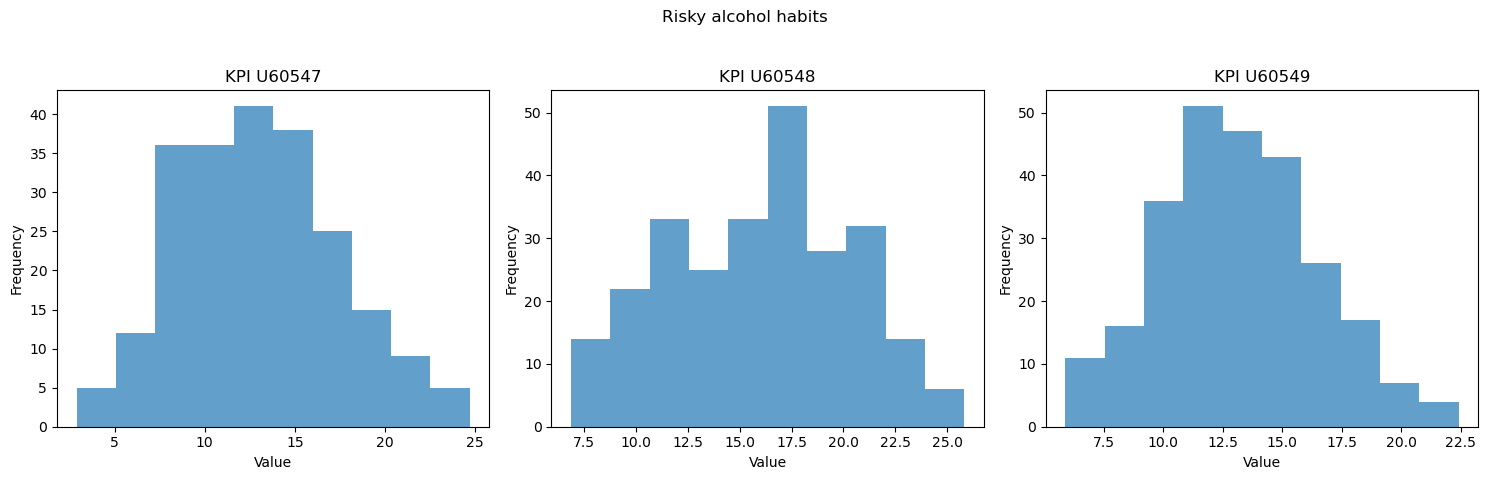

In [7]:
# Analysing the health contributors with different levels of education
# This is done to determine what KPIs are relevant to our analysis
education_health_kpis = [
    'U60507', 'U60508', 'U60509', # Good self-assessed health
    'U60510', 'U60511', 'U60512', # Obesity
    'U60514', 'U60515', 'U60516', # Good self-assessed dental health
    'U60525', 'U60526', 'U60527', # Refrain from going out alone
    'U60528', 'U60529', 'U60530', # Lack of trust in others
    'U60540', 'U60541', 'U60542', # Eat fruits and vegetables
    'U60543', 'U60544', 'U60545', # Smoke daily
    'U60547', 'U60548', 'U60549'  # Risky alcohol habits
]

# Filter the kpi_values dataframe for the KPIs of interest
filtered_df = kpi_values[kpi_values['kpi'].isin(education_health_kpis)]

kpi_groups = {
    'Good self-assessed health': ['U60507', 'U60508', 'U60509'],
    'Obesity': ['U60510', 'U60511', 'U60512'],
    'Good self-assessed dental health': ['U60514', 'U60515', 'U60516'],
    'Refrain from going out alone': ['U60525', 'U60526', 'U60527'],
    'Lack of trust in others': ['U60528', 'U60529', 'U60530'],
    'Eat fruits and vegetables': ['U60540', 'U60541', 'U60542'],
    'Smoke daily': ['U60543', 'U60544', 'U60545'],
    'Risky alcohol habits': ['U60547', 'U60548', 'U60549']
}

# Create subplots for each category
for category, kpis in kpi_groups.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    fig.suptitle(category)

    for i, kpi in enumerate(kpis):
        subset = filtered_df[filtered_df['kpi'] == kpi]
        axes[i].hist(subset['value'], bins=10, alpha=0.7)
        axes[i].set_title(f'KPI {kpi}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

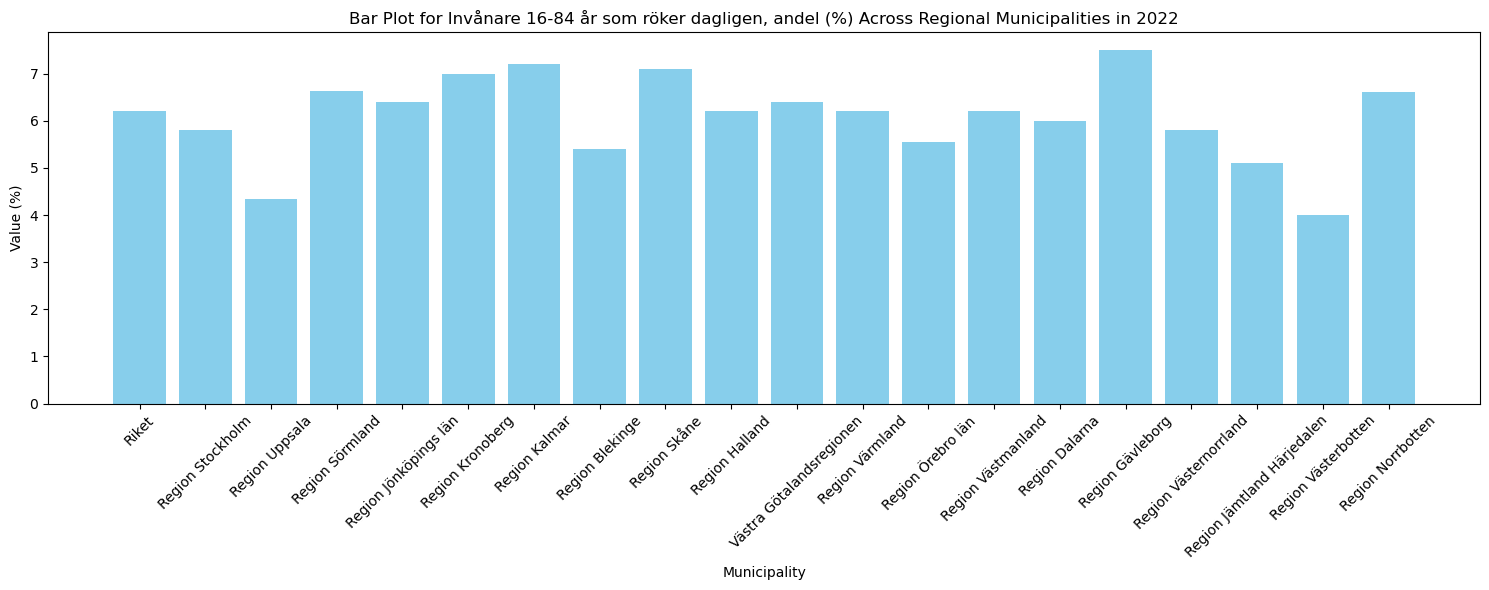

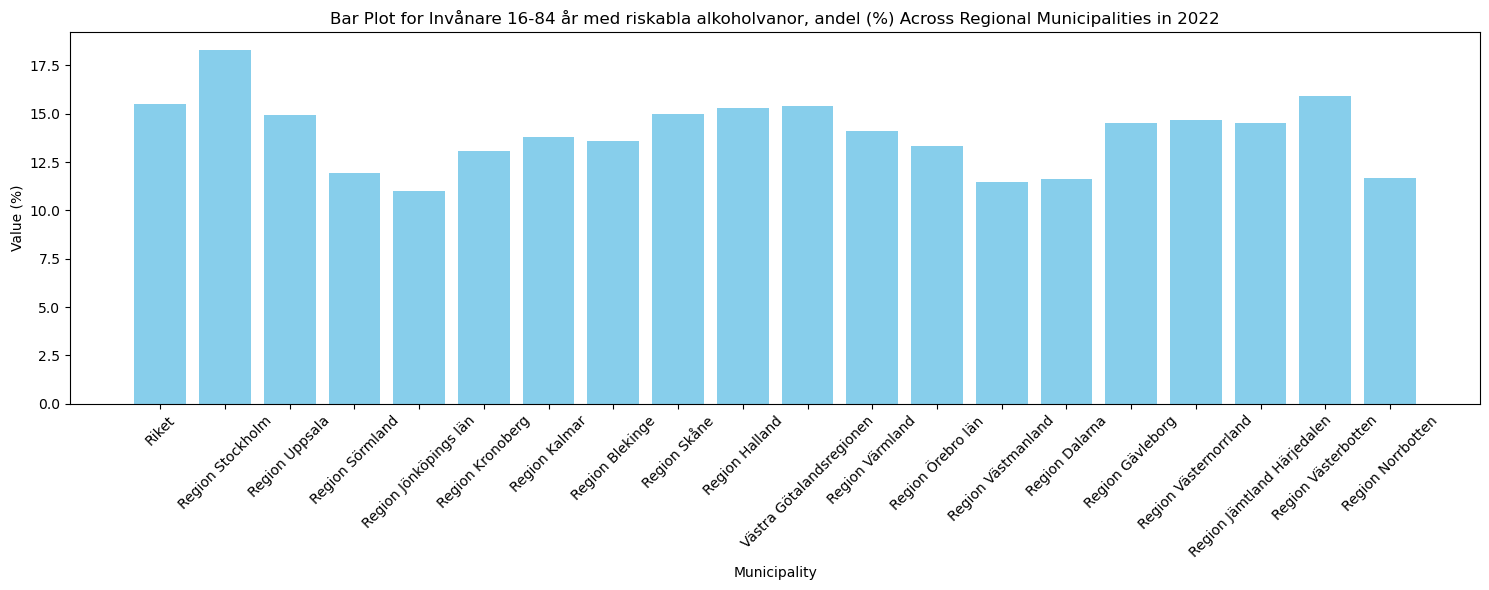

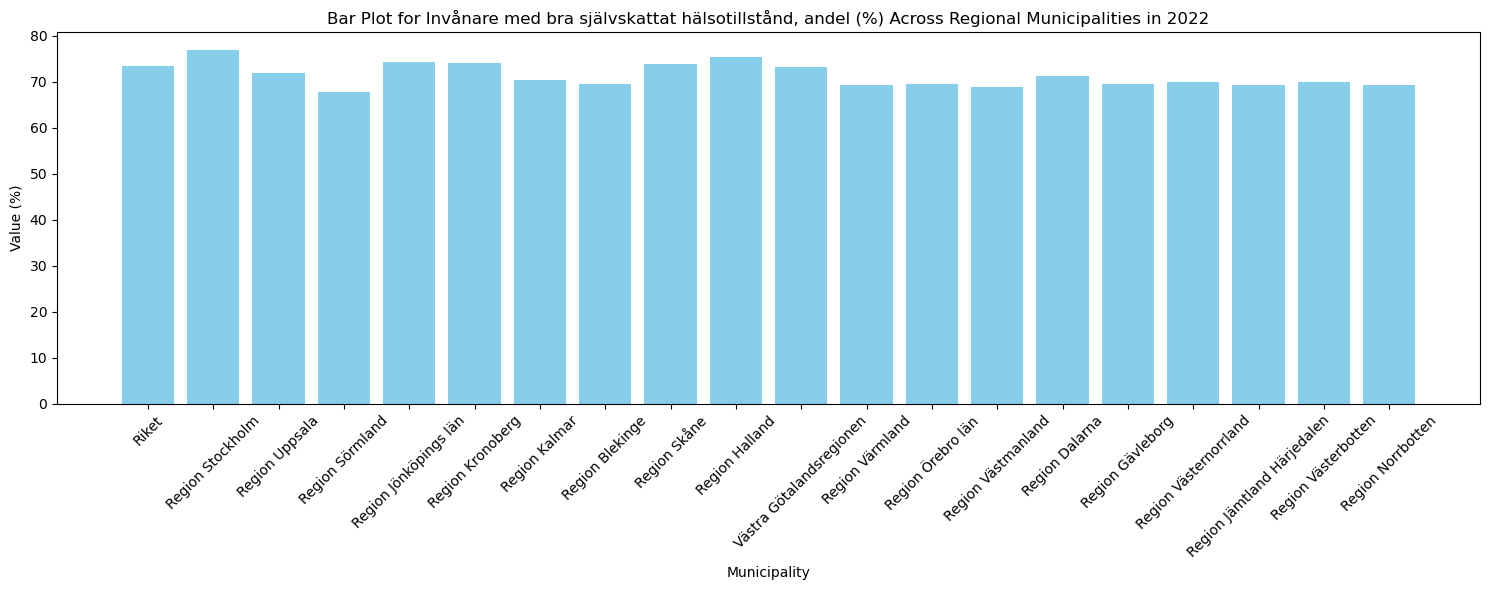

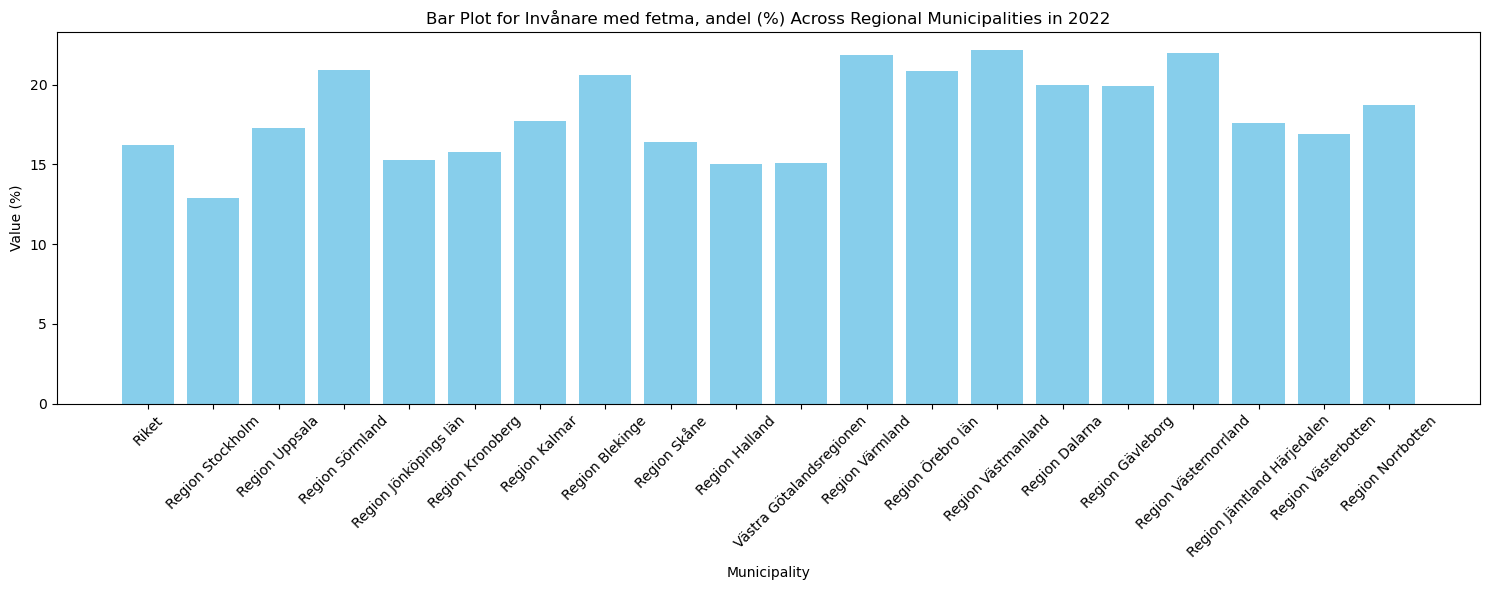

In [8]:
# Bar plots describing the distribution of the KPIs within each municipality
# Define the KPIs of interest
health_indicator_kpis = ['U01402', 'U01404', 'U01405', 'U01411']

# Create a dictionary to map KPI IDs to their names
kpi_names = pd.Series(kpi_data.title.values, index=kpi_data.id).to_dict()

# Create a dictionary to map municipality codes to their names
municipality_names = pd.Series(municipalities_data.title.values, index=municipalities_data.id).to_dict()

# Define the municipality codes for the regional municipalities
regional_municipality_codes = [0, 1, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25]

# Filter and plot data for each KPI
for kpi in health_indicator_kpis:
    # Filter for the KPI, total population, the year 2022, and the specified municipalities
    kpi_data_filtered = kpi_values[(kpi_values['kpi'] == kpi) &
                                   (kpi_values['gender'] == 'T') &
                                   (kpi_values['period'] == 2022) &
                                   (kpi_values['municipality'].isin(regional_municipality_codes))].copy()

    # Get the name of the KPI
    kpi_name = kpi_names.get(kpi, "Unknown KPI")

    # Map the municipality codes to names directly using the dictionary
    kpi_data_filtered['municipality_name'] = kpi_data_filtered['municipality'].map(municipality_names)

    # Check if there are any 'Unknown' mappings which can indicate a mismatch in the data
    if 'Unknown' in kpi_data_filtered['municipality_name'].values:
        print(f"Warning: Some municipality codes could not be found in the mapping dictionary for KPI {kpi}")

    # Plotting the bar plot
    plt.figure(figsize=(15, 6))
    plt.bar(kpi_data_filtered['municipality_name'], kpi_data_filtered['value'], color='skyblue')
    plt.title(f'Bar Plot for {kpi_name} Across Regional Municipalities in 2022')
    plt.xlabel('Municipality')
    plt.ylabel('Value (%)')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()

In [9]:
# List of KPI IDs for each category
health_kpis = ['N00340', 'U01402', 'U01404', 'U01405', 'U01411', 'N90001']
education_kpis = ['N00341']
income_kpis = ['N00337', 'N00338', 'N00906', 'N00907']

# Filtering the kpi_values dataframe to create separate dataframes for each category
health_df = kpi_values[kpi_values['kpi'].isin(health_kpis)]
education_df = kpi_values[kpi_values['kpi'].isin(education_kpis)]
income_df = kpi_values[kpi_values['kpi'].isin(income_kpis)]

# Display the first few rows of each filtered dataframe to verify
print(health_df.head())
print(education_df.head())
print(income_df.head())

         kpi  municipality  period gender      value
2962  N00340             0    2022      T  54.176671
2963  N00340             1    2022      T  73.856615
2964  N00340             3    2022      T  62.540901
2965  N00340             4    2022      T  28.396507
2966  N00340             5    2022      T  53.474125
         kpi  municipality  period gender      value
2984  N00341             0    2022      T  50.310387
2985  N00341             1    2022      T  50.000000
2986  N00341             3    2022      T  53.337168
2987  N00341             4    2022      T  44.256623
2988  N00341             5    2022      T  50.887734
         kpi  municipality  period gender      value
2896  N00337             0    2022      T  54.874662
2897  N00337             1    2022      T  63.085940
2898  N00337             3    2022      T  50.378652
2899  N00337             4    2022      T  20.259926
2900  N00337             5    2022      T  58.050222


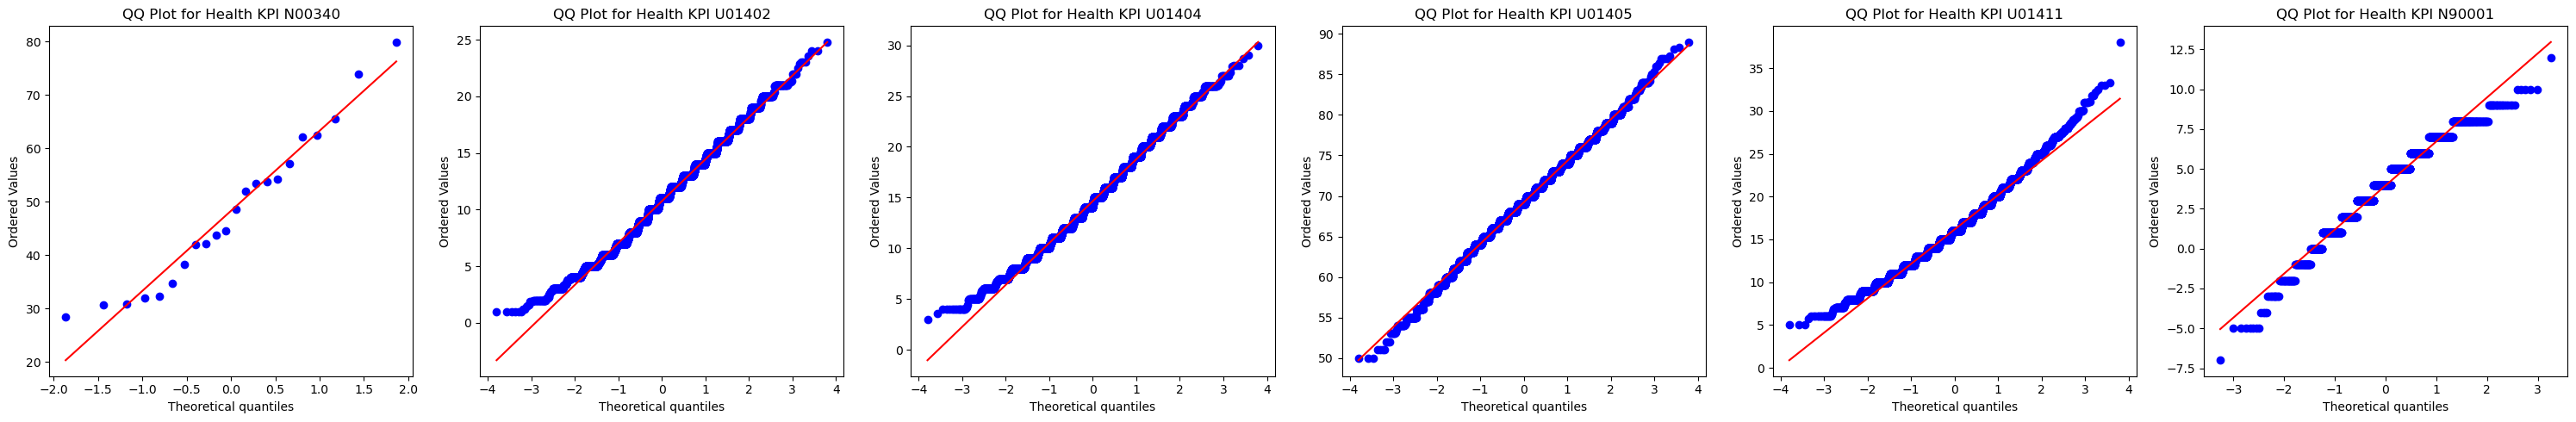

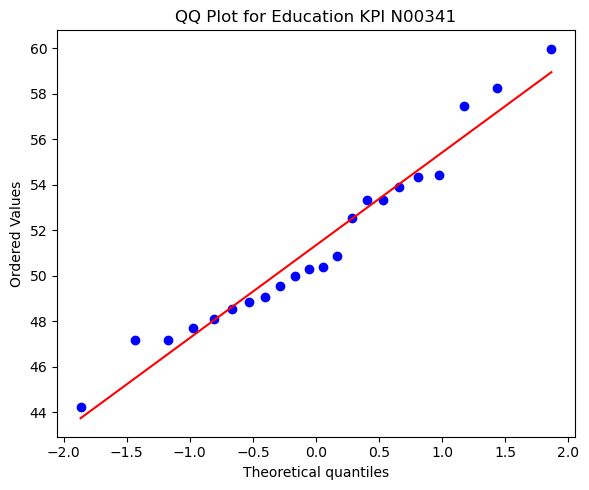

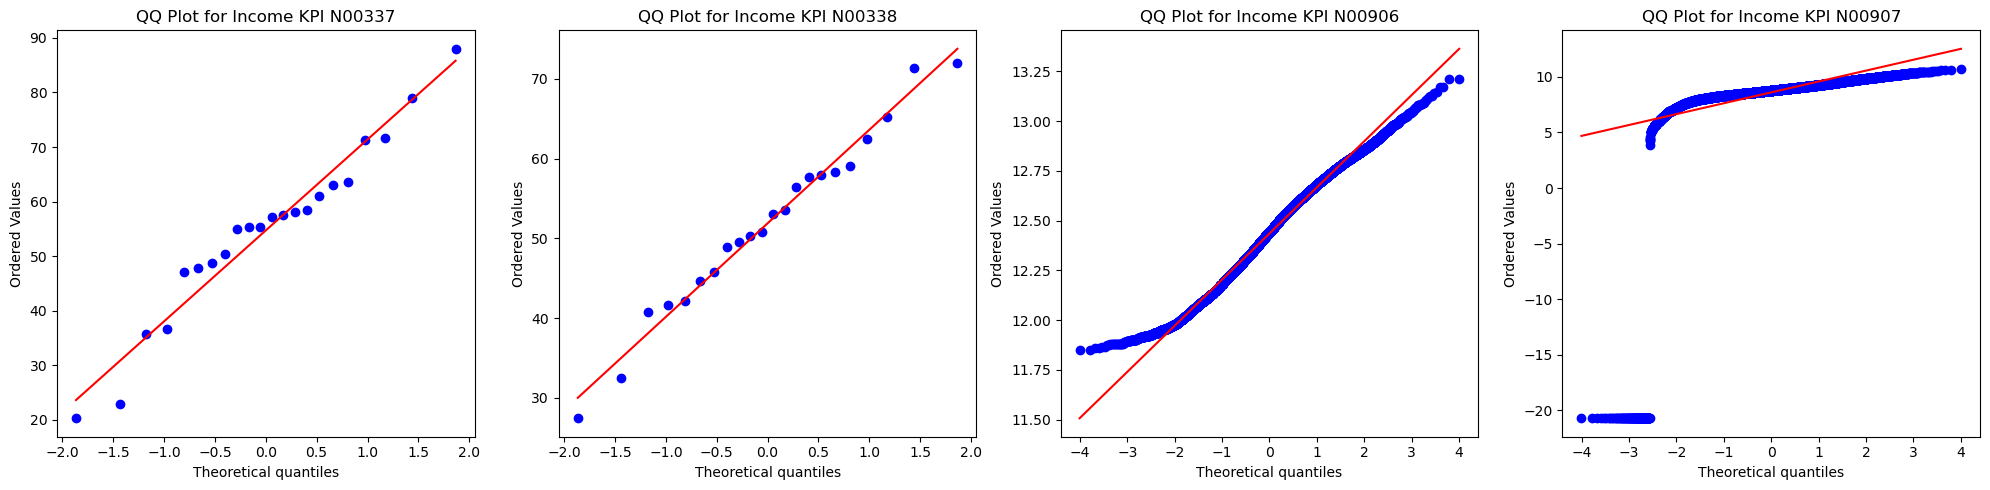

In [21]:
# Define which KPIs should be log-transformed
log_transform_kpis = ['N00906', 'N00907']

def create_qq_plots_for_kpis(kpi_list, df, category_name):
    num_plots = len(kpi_list)
    if num_plots == 1:
        fig, ax = plt.subplots(1, num_plots, figsize=(6, 5))
        ax = [ax]  # Make it a list so we can use indexing
    else:
        fig, ax = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

    for i, kpi in enumerate(kpi_list):
        # Filter for the KPI and total population
        data = df[df['kpi'] == kpi]['value']

        # Check if log transformation is needed
        if kpi in log_transform_kpis:
            # Apply log transformation, avoiding log(0) by adding a small constant
            data = np.log(data + 1e-9)

        # Generate QQ plot
        stats.probplot(data, dist="norm", plot=ax[i])
        ax[i].set_title(f'QQ Plot for {category_name} KPI {kpi}')

    plt.tight_layout()
    plt.show()

# Generate QQ plots for health, education, and income KPIs
create_qq_plots_for_kpis(health_kpis, health_df, 'Health')
create_qq_plots_for_kpis(education_kpis, education_df, 'Education')
create_qq_plots_for_kpis(income_kpis, income_df, 'Income')

 ### Exploratory Data Analysis

* Show the histogram of some selected KPIs and describe your observation.
* Show the dependence of some selected variables and describe your observation.
* Describe the data using its range, sample mean, sample standard deviation and some quantiles. Describe your observation.
* Choose another visualization method to explore the data set.
* Draw conclusion from your exploratory analysis

### Probability Distribution

* Use probability distributions to describe some selected variables. State why they are interesting to look at and describe your observation.
* What are the parameters in the distribution? Estimate these parameters.
* Use hypothesis testing to show some interesting conclusions.

### Predictive Analysis

* Apply two predictive machine learning models to solve your problem. You can use anything from scikit learn or other libraries.
* Evaluate their performance. Which one do you prefer and why? Conduct hypothesis testing to answer this question.

### Conclusion

* State again your problem and the motivation.
* Draw a final conclusion.
* If you keep working on this project, what would be the next step?   

### References:
- Silhouette (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Silhouette_%28clustering%29 (Accessed: 10 December 2023).